# $R_t$ MCMC
For this experiment, we assume a functional form for the time-varying reproduction number 
$$
  R_t = R^{before} + \frac{R^{after} - R^{before}}{1 + e^{-k(t - m)}}
$$
and then generate synthetic data using specified parameters of ($R^{before}, R^{after}, k, \text{and } m$)to generate a epidemic curve using a Poisson process.

We then use a Bayesian MCMC approach to infer our 4 parameters using priors
*   $R^{before} \sim U(a_{before}, b_{before})$
*   $R^{after} \sim U(a_{after}, b_{after})$
*   $k \sim U(a,b)$
*   $m \sim U(0, n_t)$

and likelihood
$$
Pr(\hat{i}_t \mid i_t, \theta ) \sim \text{StudentT}(\text{mean} = i_t, \text{width} = \sigma\sqrt{i_t})
$$
where $\hat{i}_t$ is the estimate daily reported cases, $i_t$ is the daily reported cases from our synthetic data at time step $t$, and $\theta = \{R^{before}, R^{after}, k, m\}$.

$$
f(x \mid \mu, \lambda, \nu)=\frac{\Gamma\left(\frac{\nu+1}{2}\right)}{\Gamma\left(\frac{\nu}{2}\right)}\left(\frac{\lambda}{\pi \nu}\right)^{\frac{1}{2}}\left[1+\frac{\lambda(x-\mu)^2}{\nu}\right]^{-\frac{\nu+1}{2}}
$$









## Simulate Data

In [1]:
%matplotlib inline

import pymc as pm

import numpy as np
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff

import scipy.stats

In [2]:
print(f"pyMC version: {pm.__version__}")

pyMC version: 5.0.1


In [3]:
# import aesara
# aesara.config.floatX = "float32"

import pytensor
import pytensor.tensor as pt
from pytensor import scan

pytensor.config.floatX = "float32"

In [4]:
class simulate_data():
  def __init__(self, rt_0, rt_1, midpoint, k, n_t, t_I, N, S0, I0):
    r"""
    Args:
      rt_0 (float): Rt value before midpoint
      rt_1 (float): Rt value after midpoint
      midpoint (int): Sigmoid midpoint
      k (float): Logistic growth rate
      n_t (int): Number of days
      t_I (float):
      N (int): Population
      I0 (int): Intitial number of infectors
    """
    self.rt_0 = rt_0
    self.rt_1 = rt_1
    self.midpoint = midpoint
    self.k = k
    self.n_t = n_t

    self.t_I = t_I
    self.N = N
    self.I0 = I0
    self.S0 = N - I0

    self.rt = self.sigmoid(rt_0, rt_1, midpoint, k, n_t)

    self.S, self.I, self.R, self.i = self.generate_sir_stoch(self.rt, t_I, N, S0, I0, n_t)
 
  def sigmoid(self, rt_0, rt_a, midpoint, k, n_t):
    """Computes sigmoid curve"""
    t = np.arange(0, n_t)
    sigmoid = rt_0 + (rt_1 - rt_0) / (1 + np.exp(-k*(t - midpoint)))
    return sigmoid

  def construct_beta(self, rt, t_I):
    return rt / t_I

  def generate_sir_stoch(self, rt, t_I, N, S0, I0, n_t):
    beta = self.construct_beta(rt, t_I)
    S = [S0]
    I = [I0]
    R = [0]
    i = [0]
    for t in range(n_t):
      dSI = np.random.poisson(beta[t]*I[t]*S[t]/N)
      dIR = np.random.poisson(I[t]/t_I)

      S_new = min(max(S[t]-dSI,0),N)
      I_new = min(max(I[t]+dSI-dIR,0),N)
      R_new = min(max(R[t]+dIR,0),N)

      S.append(S_new)
      I.append(I_new)
      R.append(R_new)
      i.append(dSI)
    return S, I, R, i
  
  def plot_rt(self):
    plt.plot(self.rt, '.-')
    plt.title('Rt')
    plt.show()

  def plot_SIR(self):
    plt.plot(self.S, '.-', label='S')
    plt.plot(self.I, '.-', label='I')
    plt.plot(self.R, '.-', label='R')
    plt.title('Stochastic SIR')
    plt.legend()
    plt.show()
  
  def plot_obs(self):
    plt.plot(self.i, '.')
    plt.title('Stochastic Daily Case Counts')
    plt.show()

In [26]:
rt_0 = 1.4
rt_1 = 3
midpoint = 100
k = 0.1
n_t = 365

t_I = 4.
N = 100_000.
S_init = 99_900.
I_init = 100.


np.random.seed(1994)

data = simulate_data(rt_0, rt_1, midpoint, k, n_t, t_I, N, S_init, I_init)

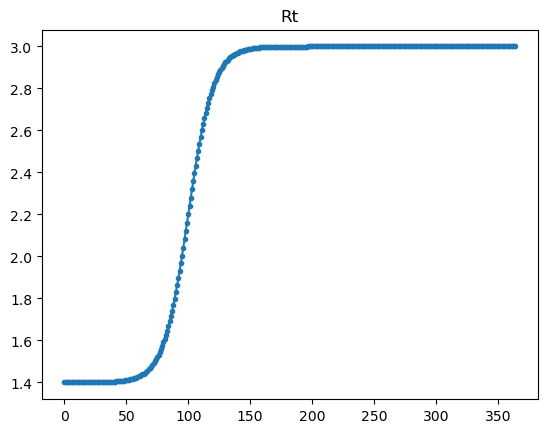

In [27]:
data.plot_rt()

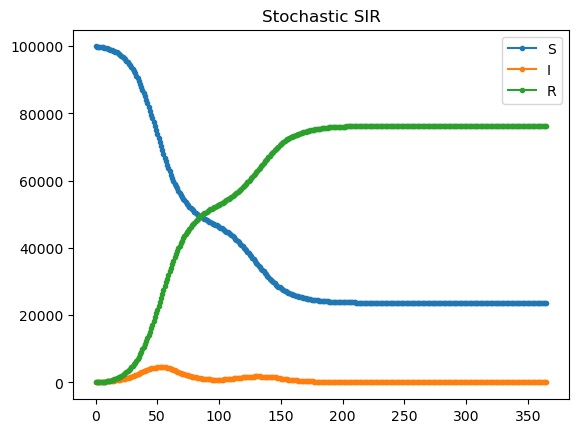

In [28]:
data.plot_SIR()

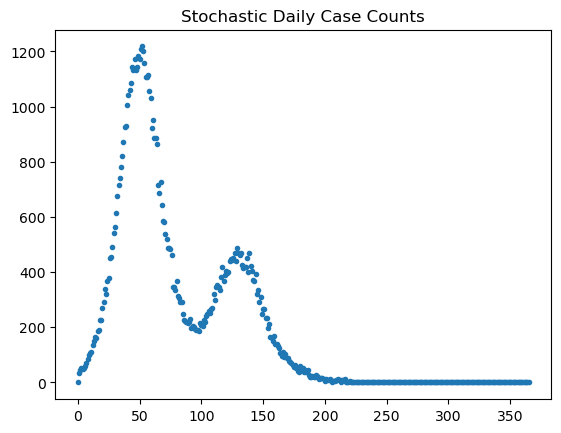

In [29]:
data.plot_obs()

## Model

In [42]:
with pm.Model() as model1:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)
    
    rt_0 = pm.Uniform("rt_0", 1.0, 4)
    rt_1 = pm.Uniform("rt_1", 2.0, 4)
    k = pm.Uniform("k", 0.01, 2)
    midpoint = pm.Uniform("midpoint", 50, 150)
    
    t = np.arange(n_t)
    
    Rt = pm.Deterministic("Rt", rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*(t - midpoint))))
    beta_t = pm.Deterministic("beta_t", Rt / t_I)
    
    def next_day(beta_t, S_t, I_t, _, t_I, N, dt=1):
        dSI = beta_t * I_t * S_t / N
        dIR = I_t / t_I
        S_t = S_t - dSI
        I_t = I_t + dSI - dIR
        S_t = pt.clip(S_t, 0, N)
        I_t = pt.clip(I_t, 0, N)
        
        S_t = S_t.astype('float32')
        I_t = I_t.astype('float32')
        dSI = dSI.astype('float32')
        
        return S_t, I_t, dSI
    
    I0 = I_init
    S0 = N - I0
    new_I_0 = pt.zeros_like(I0, dtype="float32")
    
    results, _ = scan(
        fn=next_day,
        sequences=[beta_t],
        outputs_info=[S_init, I_init, new_I_0],
        non_sequences=[t_I, N, dt],
        n_steps=n_t
    )
    
    S, I, i = results
    i_modeled = pm.Deterministic("i", i)
    
    i_est = pm.StudentT("i_est",
                        nu=4,
                        mu=i_modeled,
                        sigma=2,
                        observed=data.i[1:]
                       )
    
    # step = pm.Metropolis()
    trace = pm.sample(1000, tune=1000, chains=4, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, rt_0, rt_1, k, midpoint]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2048 seconds.


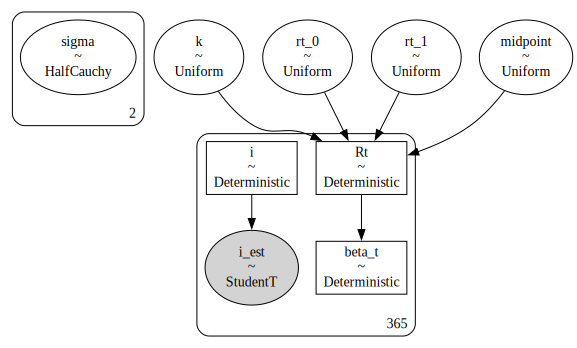

In [81]:
pm.model_to_graphviz(model1)

In [43]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [159]:
with model1:
    pm.compute_log_likelihood(trace)

In [197]:
trace.log_likelihood

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, i_est_dim_0: 365)
Coordinates:
  * chain        (chain) int32 0 1 2 3
  * draw         (draw) int32 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * i_est_dim_0  (i_est_dim_0) int32 0 1 2 3 4 5 6 ... 359 360 361 362 363 364
Data variables:
    i_est        (chain, draw, i_est_dim_0) float32 -2.206 -5.986 ... -1.674
Attributes:
    created_at:                 2023-01-17T16:10:30.484976
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.0.1

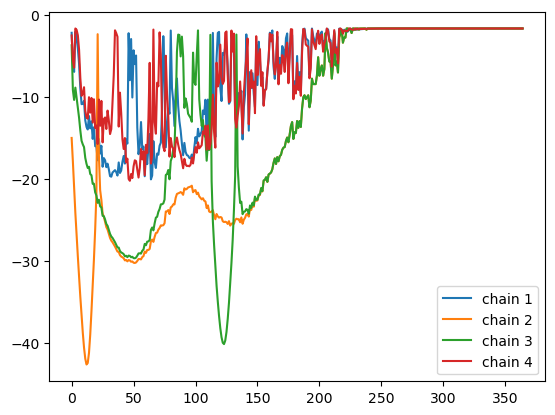

In [196]:
for x in range(4):
    plt.plot(trace.log_likelihood.sel(chain=x).mean("draw").to_array().values.ravel(), label=f"chain {x+1}")

plt.legend()

array([[<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>],
       [<AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_0'}>],
       [<AxesSubplot: title={'center': 'rt_1'}>,
        <AxesSubplot: title={'center': 'rt_1'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'k'}>],
       [<AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'midpoint'}>],
       [<AxesSubplot: title={'center': 'Rt'}>,
        <AxesSubplot: title={'center': 'Rt'}>],
       [<AxesSubplot: title={'center': 'beta_t'}>,
        <AxesSubplot: title={'center': 'beta_t'}>],
       [<AxesSubplot: title={'center': 'i'}>,
        <AxesSubplot: title={'center': 'i'}>]], dtype=object)

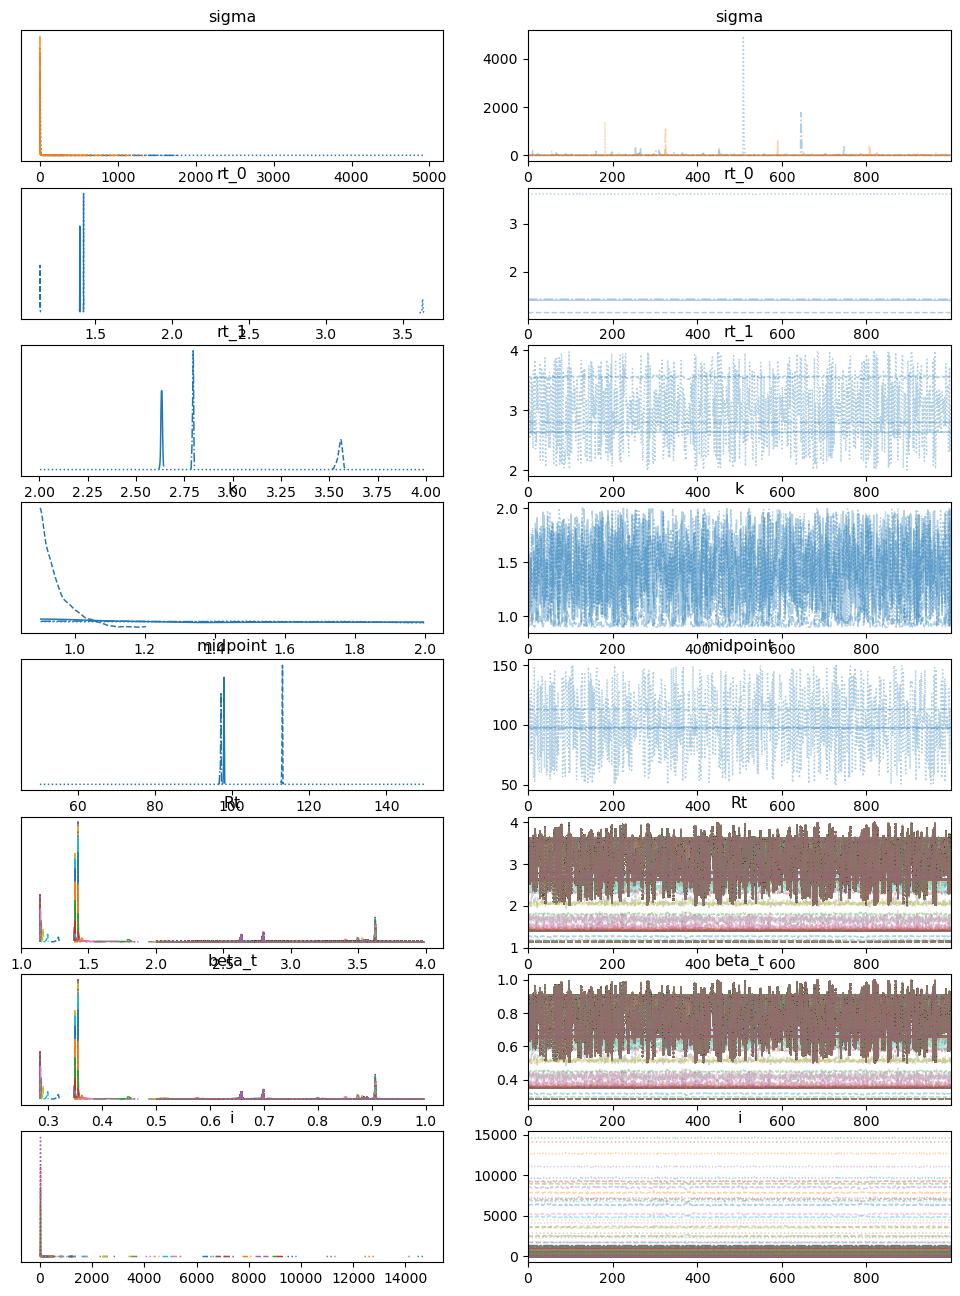

In [44]:
az.plot_trace(trace)
# az.plot_trace(trace, 
#              combined=True,
#              priors=[pm.Uniform.dist(1.0, 4), pm.Uniform.dist(2.0, 4), pm.Uniform.dist(0.9, 2), pm.Uniform.dist(50, 150)]);

C:\Users\hyone\anaconda3\envs\rt-estimation\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1101) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'sigma\n0'}>,
        <AxesSubplot: title={'center': 'sigma\n1'}>,
        <AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_1'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'Rt\n0'}>,
        <AxesSubplot: title={'center': 'Rt\n1'}>],
       [<AxesSubplot: title={'center': 'Rt\n2'}>,
        <AxesSubplot: title={'center': 'Rt\n3'}>,
        <AxesSubplot: title={'center': 'Rt\n4'}>,
        <AxesSubplot: title={'center': 'Rt\n5'}>],
       [<AxesSubplot: title={'center': 'Rt\n6'}>,
        <AxesSubplot: title={'center': 'Rt\n7'}>,
        <AxesSubplot: title={'center': 'Rt\n8'}>,
        <AxesSubplot: title={'center': 'Rt\n9'}>],
       [<AxesSubplot: title={'center': 'Rt\n10'}>,
        <AxesSubplot: title={'center': 'Rt\n11'}>,
        <AxesSubplot: title={'center': 'Rt\n12'}>,
        <AxesSubplot: title={'center': '

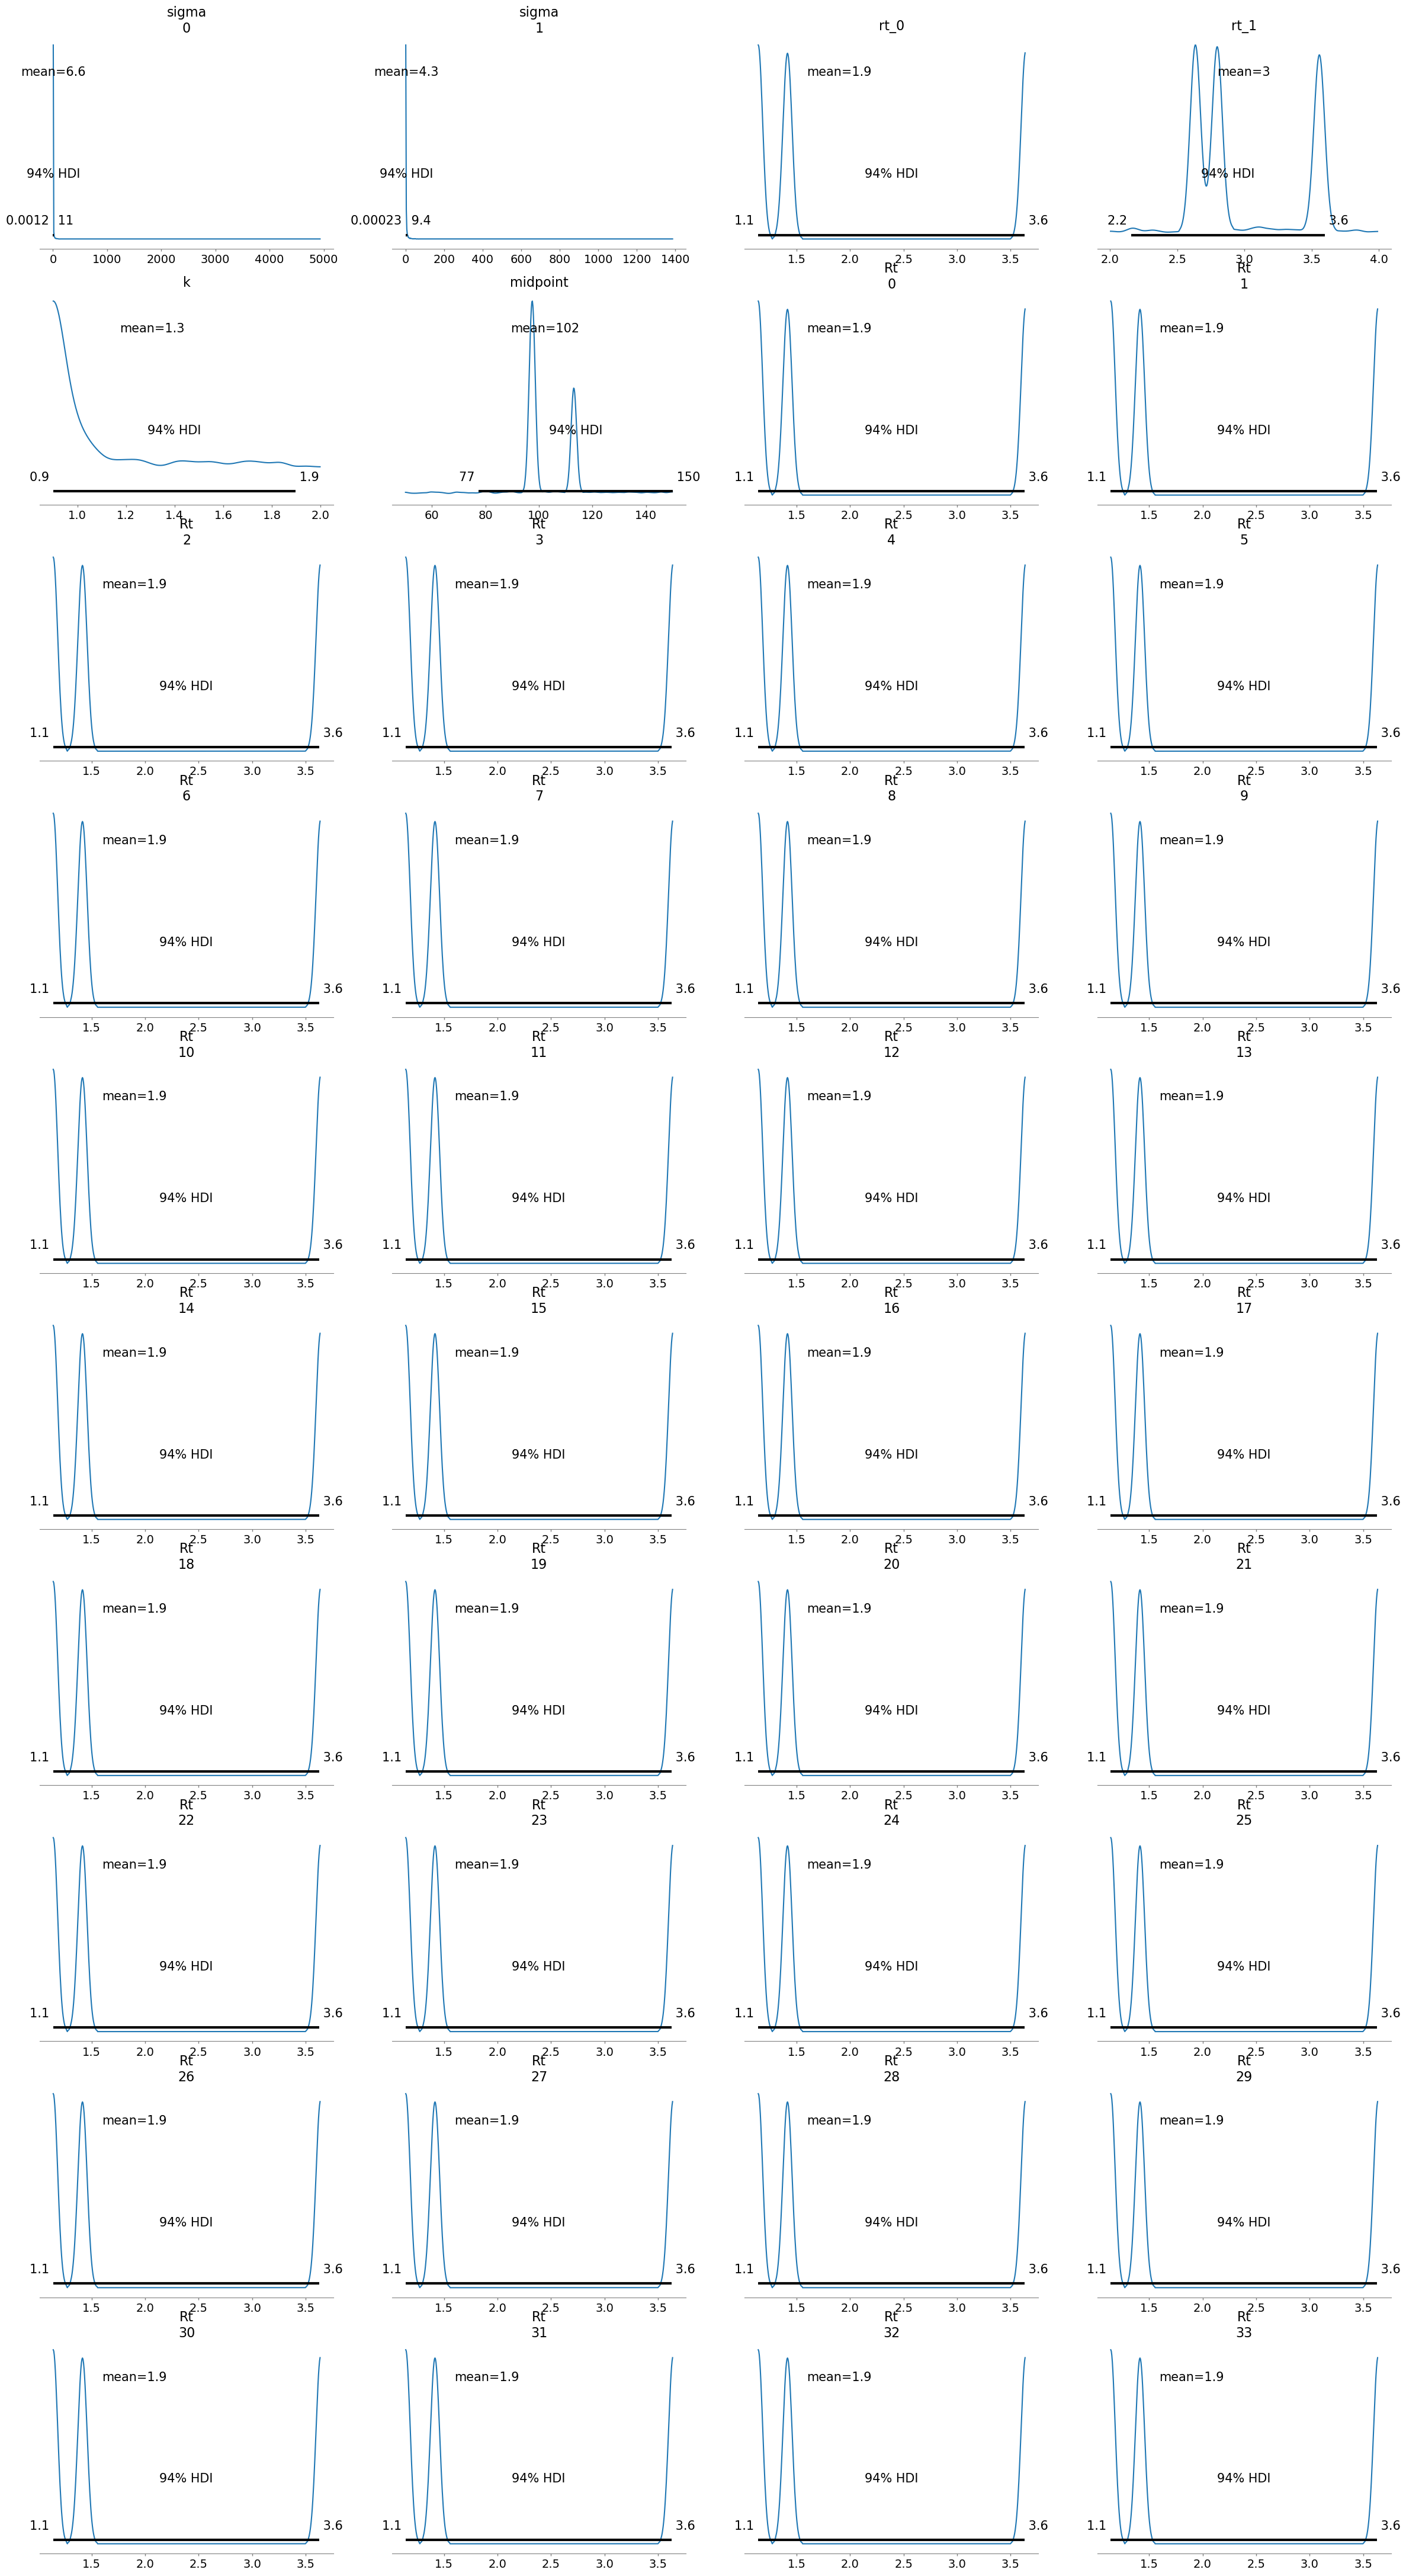

In [107]:
az.plot_posterior(trace)

C:\Users\hyone\anaconda3\envs\rt-estimation\lib\site-packages\arviz\plots\plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (1101) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<AxesSubplot: title={'center': 'sigma\n0'}>,
        <AxesSubplot: title={'center': 'sigma\n1'}>,
        <AxesSubplot: title={'center': 'rt_0'}>,
        <AxesSubplot: title={'center': 'rt_1'}>],
       [<AxesSubplot: title={'center': 'k'}>,
        <AxesSubplot: title={'center': 'midpoint'}>,
        <AxesSubplot: title={'center': 'Rt\n0'}>,
        <AxesSubplot: title={'center': 'Rt\n1'}>],
       [<AxesSubplot: title={'center': 'Rt\n2'}>,
        <AxesSubplot: title={'center': 'Rt\n3'}>,
        <AxesSubplot: title={'center': 'Rt\n4'}>,
        <AxesSubplot: title={'center': 'Rt\n5'}>],
       [<AxesSubplot: title={'center': 'Rt\n6'}>,
        <AxesSubplot: title={'center': 'Rt\n7'}>,
        <AxesSubplot: title={'center': 'Rt\n8'}>,
        <AxesSubplot: title={'center': 'Rt\n9'}>],
       [<AxesSubplot: title={'center': 'Rt\n10'}>,
        <AxesSubplot: title={'center': 'Rt\n11'}>,
        <AxesSubplot: title={'center': 'Rt\n12'}>,
        <AxesSubplot: title={'center': '

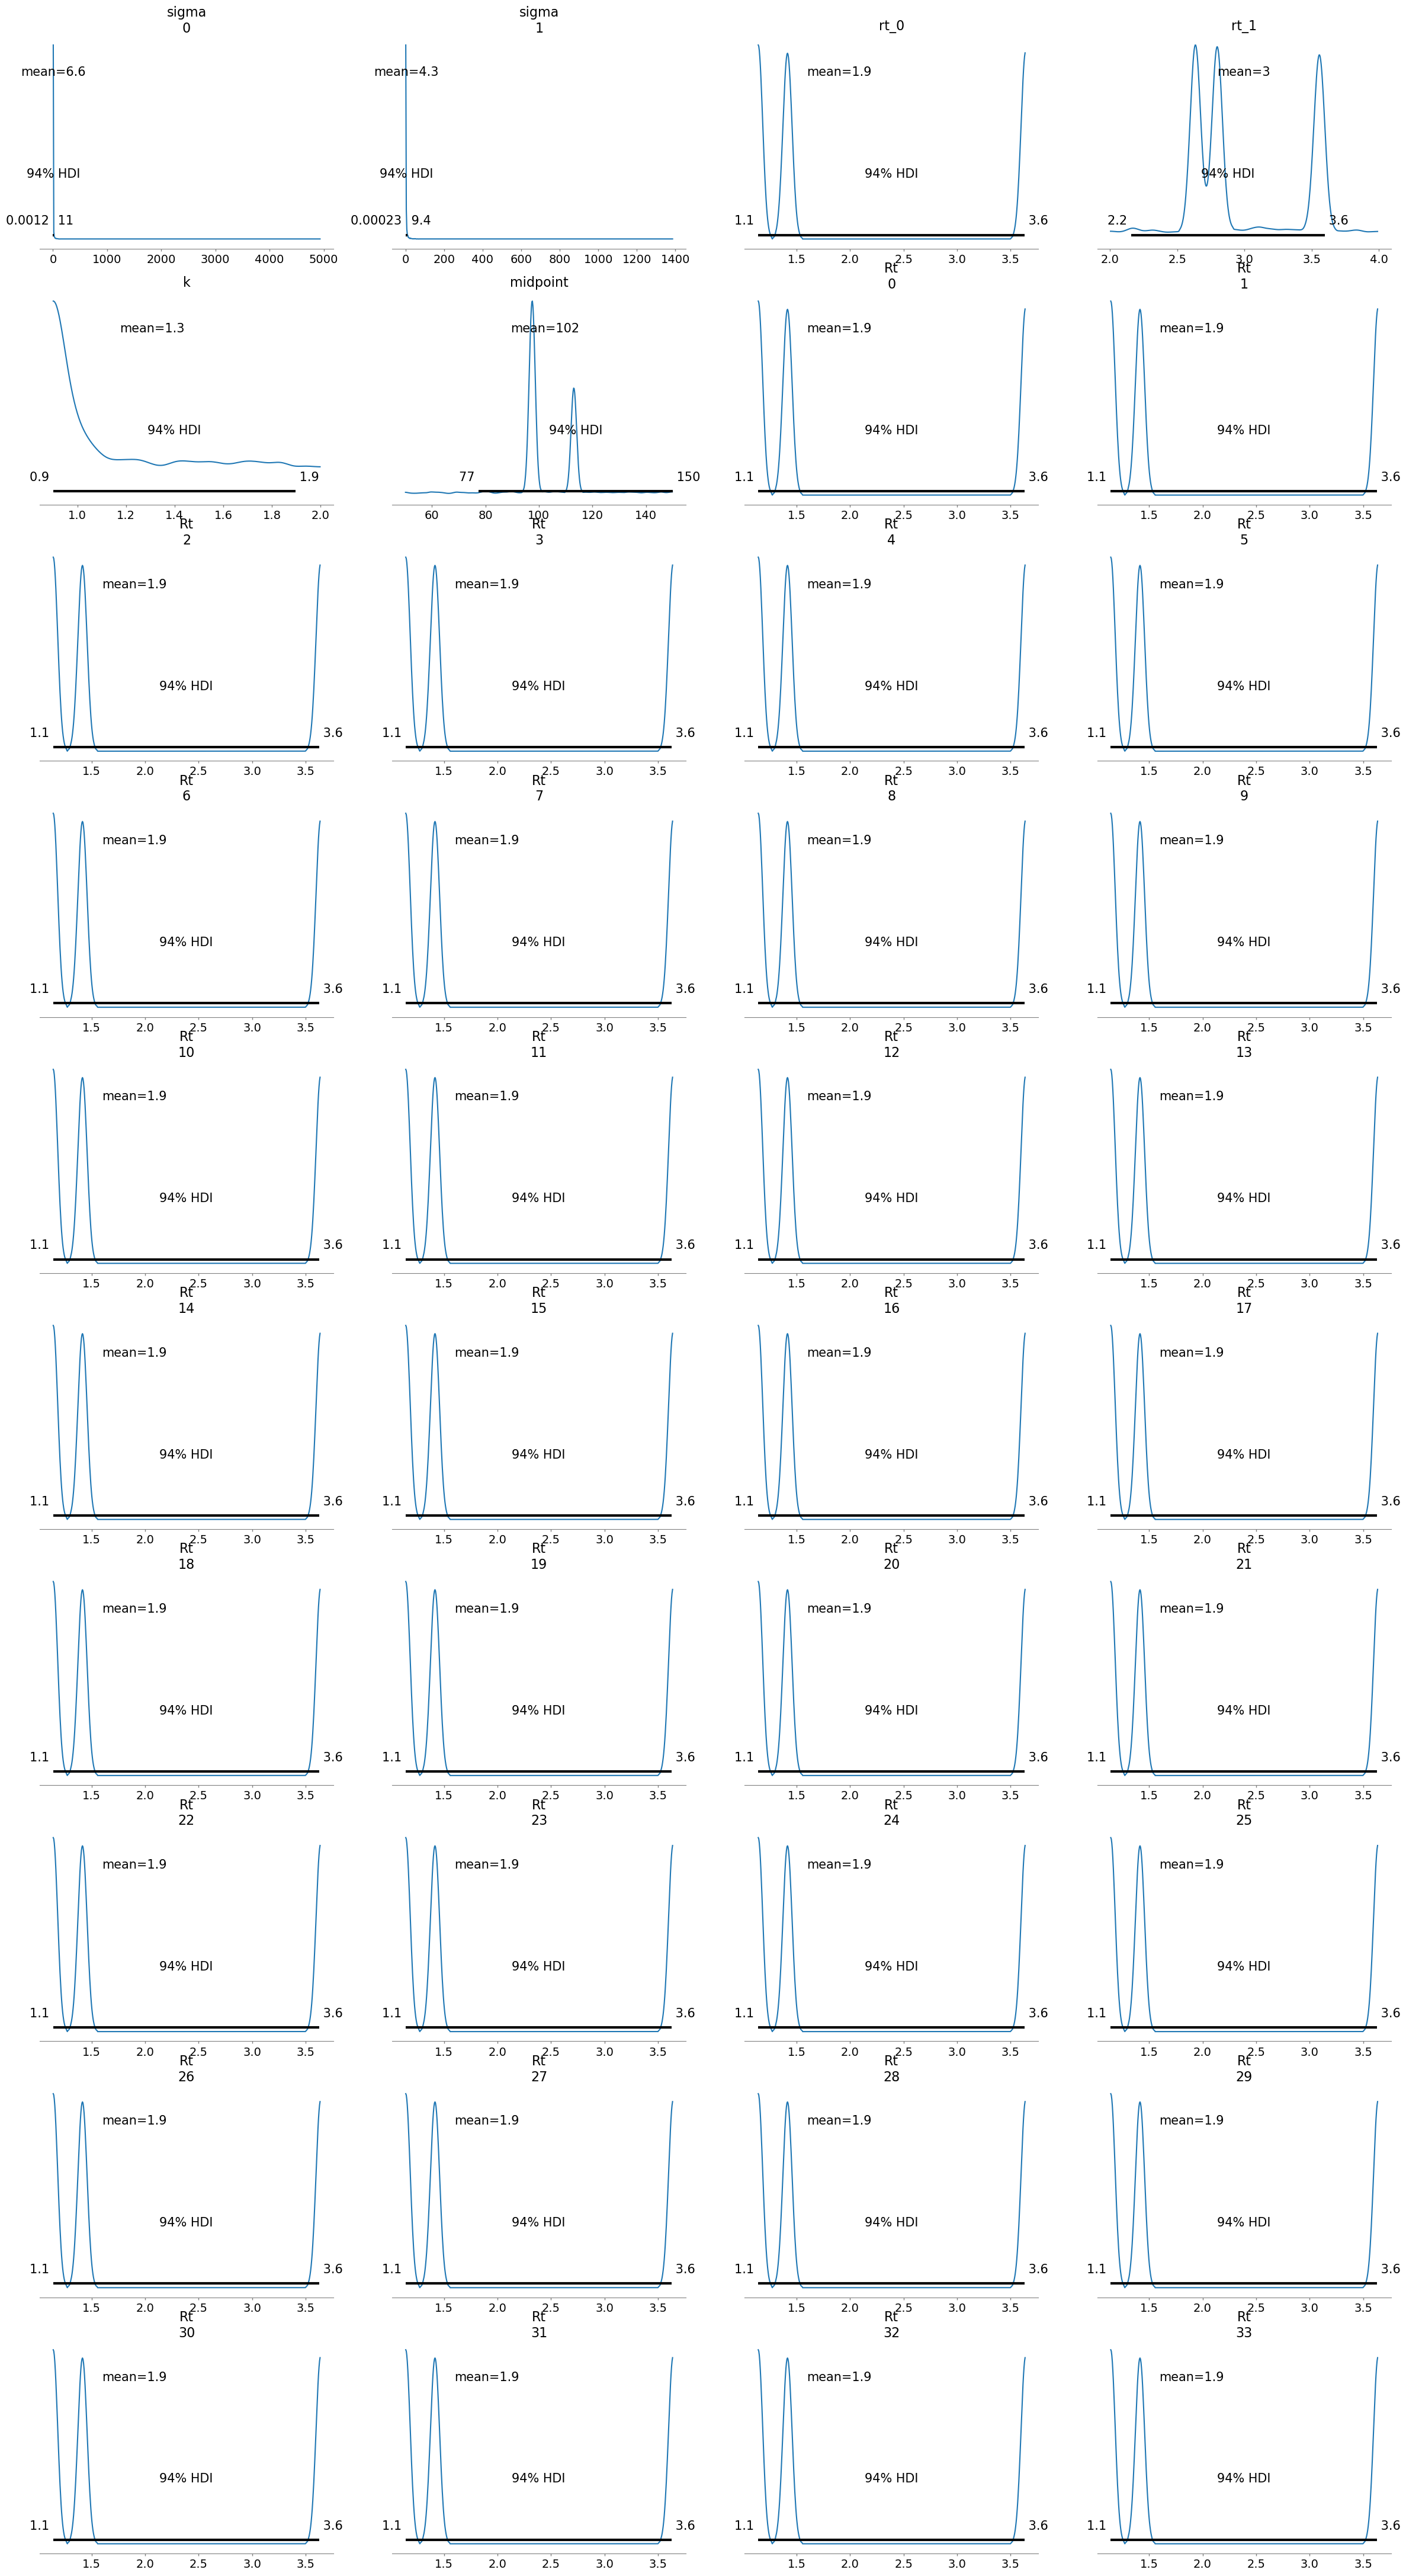

In [135]:
az.plot_posterior(trace, combine_dims={'draw'})

<AxesSubplot: >

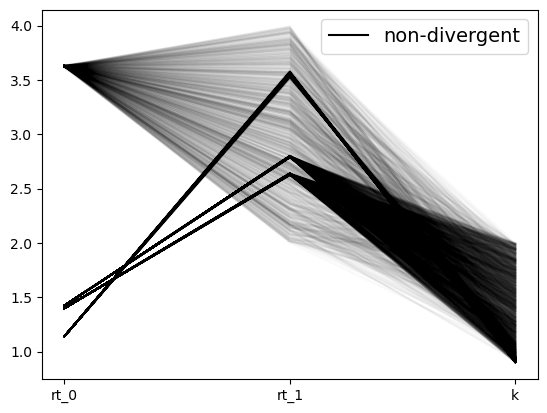

In [149]:
az.plot_parallel(trace, var_names=["rt_0", "rt_1", "k"])

<AxesSubplot: >

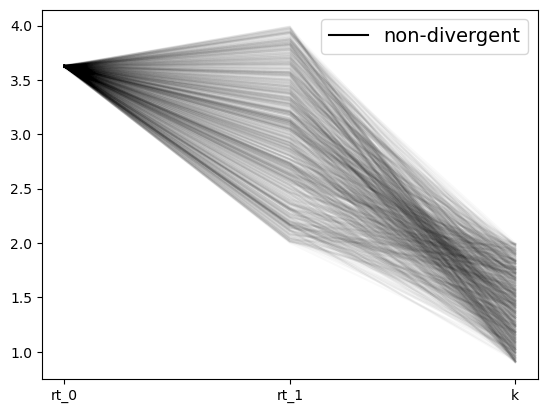

In [150]:
az.plot_parallel(trace.sel(chain=1), var_names=["rt_0", "rt_1", "k"])

<AxesSubplot: >

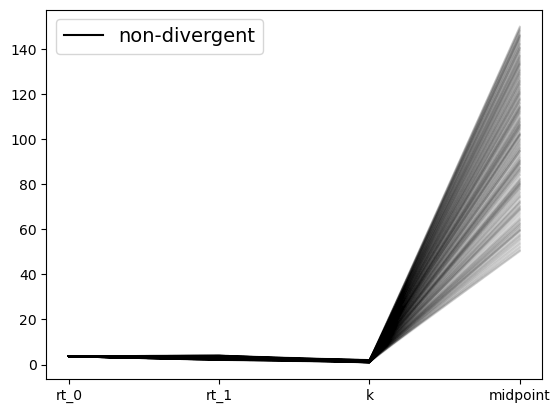

In [151]:
az.plot_parallel(trace.sel(chain=1), var_names=["rt_0", "rt_1", "k", "midpoint"])

<AxesSubplot: >

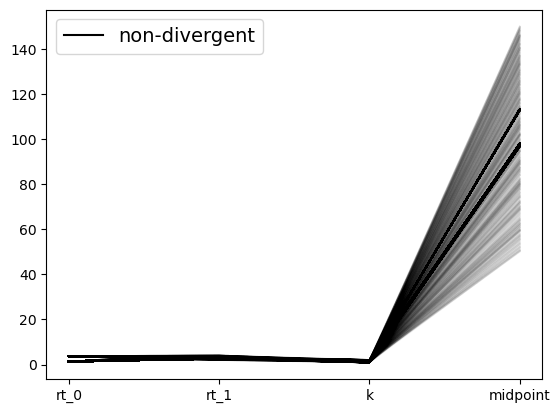

In [152]:
az.plot_parallel(trace, var_names=["rt_0", "rt_1", "k", "midpoint"])

In [139]:
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

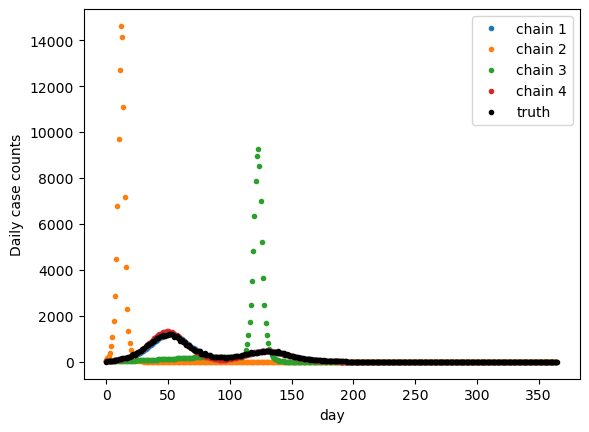

In [122]:
for x in range(4):
    plt.plot(trace.posterior["i"].data.mean(axis=1)[x], '.', label=f'chain {x+1}')
plt.plot(data.i, '.', label="truth", color='black')
plt.xlabel('day')
plt.ylabel('Daily case counts')
plt.legend()

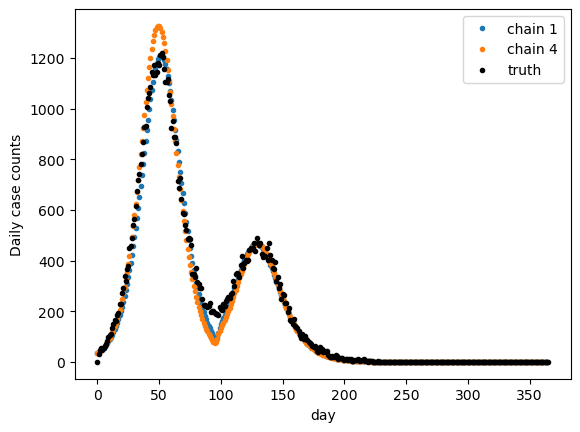

In [123]:
for x in [0,3]:
    plt.plot(trace.posterior["i"].data.mean(axis=1)[x], '.', label=f'chain {x+1}')
plt.plot(data.i, '.', label="truth", color='black')
plt.xlabel('day')
plt.ylabel('Daily case counts')
plt.legend()

In [68]:
rt_0_post_mean = trace.posterior["rt_0"].data.mean(axis=1)
rt_1_post_mean = trace.posterior["rt_1"].data.mean(axis=1)
k_post_mean = trace.posterior["k"].data.mean(axis=1)
midpoint_post_mean = trace.posterior["midpoint"].data.mean(axis=1)

print(f"posterior means {rt_0_post_mean} {rt_1_post_mean} {k_post_mean} {midpoint_post_mean}")

posterior means [1.3989211 3.6270242 1.1410642 1.4235071] [2.6331449 2.98767   3.55465   2.7952883] [1.4079931 1.4407756 0.9479779 1.4299537] [ 97.90119  101.1917   113.03778   97.064644]


In [133]:
np.mean(rt_0_post_mean)

1.8976291

In [116]:
# for i in range(4):
#     plt.plot(rt_0_post_mean[i] + (rt_1_post_mean[i] - rt_0_post_mean[i]) / (1. + np.exp(-k_post_mean[i]*(t - midpoint_post_mean[i]))), label=f"chain {i+1}")
    
# plt.plot(data.rt, label = "truth")
# plt.legend()

In [117]:
# rt_0_post_lower = trace.posterior["rt_0"].quantile(q=.025, dim=['draw'])
# rt_1_post_lower = trace.posterior["rt_1"].quantile(q=.025, dim=['draw'])
# k_post_lower = trace.posterior["k"].quantile(q=.025, dim=['draw'])
# midpoint_post_lower = trace.posterior["midpoint"].quantile(q=.025, dim=['draw'])

# rt_0_post_upper = trace.posterior["rt_0"].quantile(q=.975, dim=['draw'])
# rt_1_post_upper = trace.posterior["rt_1"].quantile(q=.975, dim=['draw'])
# k_post_upper = trace.posterior["k"].quantile(q=.975, dim=['draw'])
# midpoint_post_upper = trace.posterior["midpoint"].quantile(q=.975, dim=['draw'])


In [118]:
# for x in [0, 3]:
#     plt.plot(rt_0_post_mean[x] + (rt_1_post_mean[x] - rt_0_post_mean[x]) / (1. + np.exp(-k_post_mean[x]*(t - midpoint_post_mean[x]))), label=f"chain {i+1} mean")
#     lower = rt_0_post_lower[x].data + (rt_1_post_lower[x].data - rt_0_post_lower[x].data) / (1 + np.exp(-k_post_lower[x].data*(t - midpoint_post_lower[x].data)))
#     upper = rt_0_post_upper[x].data + (rt_1_post_upper[x].data - rt_0_post_upper[x].data) / (1. + np.exp(-k_post_upper[x].data*(t - midpoint_post_upper[x].data)))
#     # plt.fill_between(range(len(t)), lower, upper, alpha=0.3)
#     plt.plot(lower, label="lower")
    
# plt.legend()

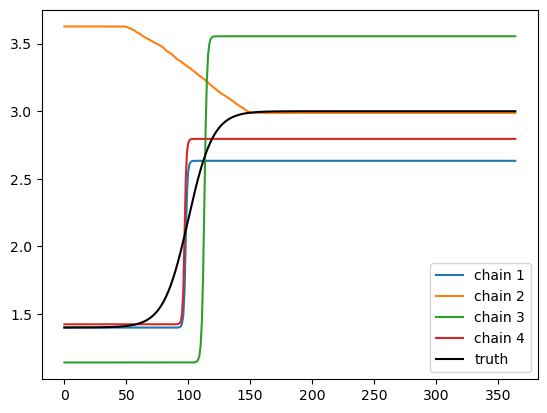

In [124]:
for x in range(4):
    plt.plot(trace.posterior["Rt"].data.mean(axis=1)[x], label=f"chain {x+1}")
    
plt.plot(data.rt, label = "truth", color='black')
plt.legend()

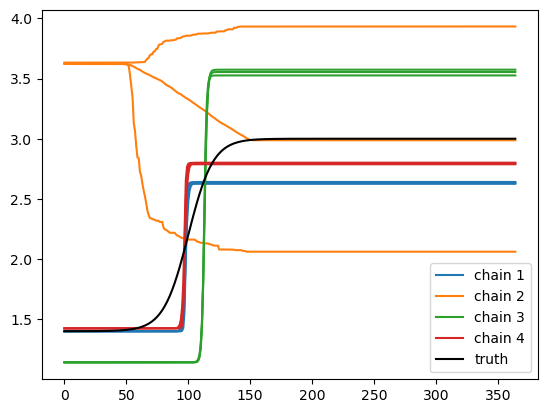

In [132]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for x in range(4):
    plt.plot(trace.posterior["Rt"].data.mean(axis=1)[x], label=f"chain {x+1}", color=colors[x])
    plt.plot(trace.posterior["Rt"].quantile(q=.025, dim=['draw']).data[x], color=colors[x])
    plt.plot(trace.posterior["Rt"].quantile(q=.975, dim=['draw']).data[x], color=colors[x])
    
plt.plot(data.rt, label = "truth", color='black')
plt.legend()

In [148]:
# az.plot_violin(trace.sel(chain=0), var_names="Rt")
# az.plot_ppc(trace)

## Archive

In [100]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

class SIR_model():
 
    def __init__(self, data) :
        self.data = data
        self.setup_SIR_model()
 
 
    def SIR_sunode(self, t, y, p):
      global t_I
      return {
          'S': -p.beta * y.S * y.I,
          'I': p.beta * y.S * y.I - y.I /t_I,
      }


    def SIR_odeint(self, t, y):
      global betafunc, t_I
      return {
          'S': -betafunc(t) * y.S * y.I,
          'I': betafunc(t) * y.S * y.I - y.I /t_I,
      }

 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.data.i),1)
        self.I0 = self.data.I[0]
        self.S0 = self.data.N - self.I0
        self.S_init = self.S0 / self.data.N
        self.I_init = self.I0 / self.data.N
        self.cases_obs_scaled = np.array(self.data.i) / self.data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        global t_I

        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
 
        with pm.Model() as model1:
          # sigma = pm.HalfCauchy("sigma", 1, shape=1)
          
          # rt_0 = pm.Normal("rt_0", self.prior['rt_0_mu'], self.prior['rt_0_std'])
          # rt_1 = pm.Normal("rt_1", self.prior['rt_1_mu'], self.prior['rt_1_std'])
          rt_0 = pm.Gamma("rt_0", mu=self.prior['rt_0_mu'], sigma=self.prior['rt_0_std'])
          rt_1 = pm.Gamma("rt_1", mu=self.prior['rt_1_mu'], sigma=self.prior['rt_1_std'])
          k = pm.Uniform("k", self.prior['k_a'], self.prior['k_b'])
          m = pm.Uniform("m", 1., 100.)

          print(model1.point_logps())

          Rt = pm.Deterministic("Rt", rt_0 + (rt_1 - rt_0) / (1. + np.exp(-k*self.time_range - m)))
          beta_t = pm.Deterministic("beta_t", Rt / t_I)

          print(model1.point_logps())

          def next_day(beta_t, S_t, I_t, _, t_I, N):
            new_I_t = beta_t / self.data.N * I_t * S_t
            S_t = S_t - new_I_t
            I_t = I_t + new_I_t - I_t / t_I
            I_t = at.clip(I_t, 0, N)

            S_t = S_t.astype('float32')
            I_t = I_t.astype('float32')
            new_I_t = new_I_t.astype('float32')

            return S_t, I_t, new_I_t
          
          new_I_0 = at.zeros_like(self.I_init, dtype="float32")

          results, _ = scan(
              fn=next_day,
              sequences=[beta_t],
              outputs_info=[self.S_init, self.I_init, new_I_0],
              non_sequences=[t_I, self.data.N],
              n_steps=len(self.time_range)
          )

          S, I, i = results

          i_modeled = pm.Deterministic("i", i)

          print(model1.point_logps())

          if(likelihood['distribution'] == 'lognormal'):
              i_est = pm.Lognormal('i_est', mu=i, sigma=2., observed=self.cases_obs_scaled)
          elif(likelihood['distribution'] == 'normal'):
              i_est = pm.Normal('i_est', mu=i, sigma=2., observed=self.cases_obs_scaled)
          elif(likelihood['distribution'] == 'students-t'):
              i_est = pm.StudentT("i_est",
                                  nu=likelihood['nu'],
                                  mu=i_modeled,
                                  sigma=likelihood['sigma']*at.sqrt(i),
                                  observed=self.cases_obs_scaled
                                  )

          step = pm.Metropolis()
          trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=4)
        
        # az.plot_posterior(trace, round_to=2, point_estimate='mode')
        # axes = az.plot_trace(trace)
        # fig = axes.ravel()[0].figure
        # fig.savefig(self.filename)
        
        # fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # # Add title
        # fig.update_layout(title_text='Curve and Rug Plot')
        # fig.update_xaxes(range=[0,7])

        return(trace)
 
sir_model = SIR_model(data)
# likelihood = {'distribution': 'lognormal', 
#               'sigma': 2}
likelihood = {'distribution': 'students-t', 
              'nu': 4,
              'sigma': 2.,
              }
prior = {'rt_0_mu': 3,
         'rt_0_std': 10,
         'rt_1_mu': 2,
         'rt_1_std': 10,
         'k_a': 0.1,
         'k_b': 10,
         }

In [ ]:
trace = sir_model.run_SIR_model(n_samples=20, n_tune=1, likelihood=likelihood, prior=prior)

$$
\begin{array}{rcl}
            \text{sigma} &\sim & \operatorname{C^{+}}(0,~1)\\\text{rt_0} &\sim & \operatorname{N}(3,~10)\\\text{rt_a} &\sim & \operatorname{N}(2,~10)\\\text{k} &\sim & \operatorname{U}(0.1,~2)\\\text{midpoint} &\sim & \operatorname{U}(0,~70)\\\text{Rt} &\sim & \operatorname{Deterministic}(f(\text{rt_0},~\text{rt_a},~\text{midpoint},~\text{k}))\\\text{beta_t} &\sim & \operatorname{Deterministic}(f(\text{rt_0},~\text{rt_a},~\text{midpoint},~\text{k}))
            \end{array}
$$

## No time varying R

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc as pm
import arviz as az
import sunode
import sunode.wrappers.as_aesara
import datetime
import shelve
from datetime import datetime as dt
import time
 
# -------- Usage --------#
# covid_obj = COVID_data('US', Population=328.2e6)
# covid_obj.get_dates(data_begin='7/11/20', data_end='7/20/20')
# sir_model = SIR_model(covid_obj)
# likelihood = {'distribution': 'lognormal', 'sigma': 2}
# prior= {'lam': 0.4, 'mu': 1/8, lambda_std', 0.5 'mu_std': 0.5 }
# sir_model.run_SIR_model(n_samples=20, n_tune=10, likelihood=likelihood)
np.random.seed(0)
 
class COVID_data():
 
    def __init__(self, country='US', Population = 328.2e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        path_to_save = ''
 
        # ------------------------- Country for inference -------------------
 
        self.country = country
        self.N = Population   # Population of the country
                         # Germany - 83.7e6
                         # US - 328.2e6
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin  #Take the data until yesterday
        self.data_end = data_end
        self.num_days_to_predict = 14
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_country = confirmed_cases.loc[confirmed_cases["Country/Region"] == country]
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print("------------ Cases for selected period ----------- ",self.cases_obs)
 
        date_data_end = confirmed_cases.loc[confirmed_cases["Country/Region"] == self.country, data_begin:data_end].columns[-1]
        month, day, year = map(int,date_data_end.split('/'))
        date_data_end = datetime.date(year+2000, month, day)
        date_today = date_data_end + datetime.timedelta(days=1)
        print("------------- Cases yesterday ({}): {} and day before yesterday: {} ------------".format(date_data_end.isoformat(), *self.cases_obs[:-3:-1]))
        self.num_days = len(self.cases_obs)
 
        day_before_start = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=-1)
        day_before_start_cases = np.array(self.cases_country.loc[:, day_before_start.strftime('%-m/%-d/%-y')])
        print("------------ Day before start and cases for that date ------------", day_before_start, day_before_start_cases)
        future_days_begin = dt.strptime(data_end, '%m/%d/%y') + datetime.timedelta(days=1)
        future_days_end = future_days_begin + datetime.timedelta(days=self.num_days_to_predict)
        self.future_days_begin_s = future_days_begin.strftime('%-m/%-d/%-y')
        self.future_days_end_s = future_days_end.strftime('%-m/%-d/%-y')
        print("------------- Future date begin and end -------------",self.future_days_begin_s, self.future_days_end_s)
        self.future_days = np.array(self.cases_country.loc[:, self.future_days_begin_s : self.future_days_end_s])[0]
        print("------------- Future days cases ------------", self.future_days)
 
 
class SIR_model():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_non_normalized(self, y, t, p):
        ds = -p[0] * y[0] * y[1] /self.covid_data.N
        di = p[0] * y[0] * y[1] / self.covid_data.N  -  p[1] * y[1]
        return [ds, di]
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
 
        # SIR model
        self.sir_model_non_normalized = DifferentialEquation(
            func=self.SIR_non_normalized,
            times=self.time_range[1:],
            n_states=2,
            n_theta=2,
            t0=0) 
 
 
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        now = dt.now()
        timenow = now.strftime("%d-%m-%Y_%H:%M:%S")
        self.filename = 'sir_' + self.covid_data.data_begin.replace('/','-') + '_' + \
            self.covid_data.data_end.replace('/','-') + '_' + timenow
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        # ------------------------ Write out metadata while the model is running -------------------#
        metadata_db_filename = 'metadata_db.db'
 
        t = time.time()
 
        with pm.Model() as model4:
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam_mu = np.log(self.prior['lam']) + self.prior['lambda_std']**2
            mu_mu = np.log(self.prior['mu']) + self.prior['mu_std']**2
            lam = pm.Lognormal('lambda', lam_mu , self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', mu_mu, self.prior['mu_std'])           # 1.5, 1.5
 
            res, _, problem, solver, _, _ = sunode.wrappers.as_aesara.solve_ivp(
              y0={
              # The initial conditions of the ode. Each variable
              # needs to specify a theano or numpy variable and a shape.
              # This dict can be nested.
                  'S': (self.S_init, ()),
                  'I': (self.I_init, ()),},
              params={
              # Each parameter of the ode. sunode will only compute derivatives
              # with respect to theano variables. The shape needs to be specified
              # as well. It it infered automatically for numpy variables.
              # This dict can be nested.
                  'lam': (lam, ()),
                  'mu': (mu, ()),
                  '_dummy': (np.array(1.), ())},
              # A functions that computes the right-hand-side of the ode using
              # sympy variables.
              rhs=self.SIR_sunode,
              # The time points where we want to access the solution
              tvals=self.time_range,
              t0=self.time_range[0]
            )
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
 
            print('Problem',problem)
            print('Solver',solver)
 
            R = 1 - (res['I'] + res['S'])
            R0 = pm.Deterministic('R0',lam/mu)

            step = pm.Metropolis()
            trace = pm.sample(self.n_samples, tune=self.n_tune, chains=4, cores=4)
            # data = az.from_pymc3(trace=trace)
 
        t1 = time.time() - t
        az.plot_posterior(trace, round_to=2, point_estimate='mode')
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
            
 
        self.metadata_db = shelve.open(metadata_db_filename)
        self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
                                    'tune': n_tune,
                                    'elapsed_time': t1,
                                    'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
                                    'likelihood': likelihood,
                                    'prior': prior }
        self.metadata_db.close()
        return(fig)
 
 
 
covid_obj = COVID_data('US', Population=328.2e6)
covid_obj.get_dates(data_begin='2/1/20', data_end='9/28/20')
sir_model = SIR_model_sunode(covid_obj)
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
# fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)
sir_model.run_SIR_model(n_samples=20, n_tune=1, likelihood=likelihood, prior=prior)

ModuleNotFoundError: ignored